- `N` represents the **total number of items** in the search space (unsorted database).
- In Grover's Algorithm, we are searching for a **marked element** among these `N` elements.


In [2]:
N = 8

In [3]:
from math import ceil, log2
n = ceil(log2(N))

In [4]:
n

3

- We need **`n` qubits** to represent `N` possible states.
   - Since a quantum register of `n` qubits can represent $2^n$ states, we need to solve:
     
     $
     2^n \geq N
     $  
   - Taking the **log base 2** gives:
     
     $
     n = \lceil \log_2(N) \rceil
     $  
   - For `N = 8`, we get:
     
     $
     n = \lceil \log_2(8) \rceil = \lceil 3 \rceil = 3
     $  
   - **Meaning:** We need **3 qubits** to represent `N = 8` elements.

In [5]:
from random import randint
winner_index = randint(0,N-1)

In [6]:
winner_index

3

In [7]:
winner_state = bin(winner_index)[2:].zfill(n)

In [8]:
winner_state

'011'

- `bin(winner_index)[2:]` converts the decimal number into a **binary string** and removes the `"0b"` prefix.
- `.zfill(n)` ensures that the binary string has exactly `n` bits (padding with leading zeros if needed).
- If `winner_index = 3`, the correct solution is at index `3`.
- This variable is expected to store the **index of the correct solution** (the item we are searching for).
- 
**Example: If `winner_index = 3` (decimal 3 in 3-bit binary)**  
   ```python
   bin(3)  # '0b11'
   bin(3)[2:]  # '11'
   '11'.zfill(3)  # '011' (adds one leading zero)


**Why is this useful in Grover’s Algorithm?**
- The algorithm searches for a special state (the **marked state**).
- `winner_state` is the **target quantum state** that Grovers Algorithm will amplify.

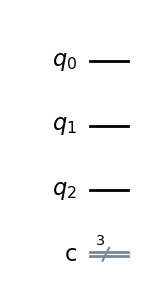

In [9]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(n,n)
qc.draw('mpl')

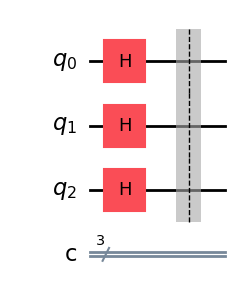

In [10]:
for i in range(n):
    qc.h(i)
qc.barrier()
qc.draw('mpl')

In [12]:
def Householder():
    import numpy as np
    Refl = np.identity(N)
    Refl[winner_index,winner_index]=-1
    from qiskit.quantum_info import Operator
    Refl_Op = Operator(Refl)
    n_qubits = []
    for i in range(n):
        n_qubits.append(i)
    qc.unitary(Refl_Op,qubits=n_qubits, label = 'Uw')
    qc.barrier()
    return qc

- `Operator` from Qiskit is used to define **quantum operations from matrices**.
 
 ```python
Refl = np.identity(N)
Refl[winner_index, winner_index] = -1
```
- This creates an **N × N identity matrix**, where `N` is the total number of states.
- The **Householder reflection matrix** in Grovers Algorithm flips the phase of the **marked state** (the correct solution).
- The diagonal matrix `Refl` has `1`s everywhere **except** at `winner_index`, where it has `-1`.



```python
Refl_Op = Operator(Refl)
```
- Converts the `Refl` **NumPy matrix** into a **Qiskit Operator**, allowing it to be applied as a quantum gate.

```python
n_qubits = []
for i in range(n):
    n_qubits.append(i)
```
- This creates a list of qubit indices from `0` to `n-1` (all the qubits needed for the operation).


```python
qc.unitary(Refl_Op, qubits=n_qubits, label='Uw')
```
- Applies the Householder reflection as a **unitary gate** (`Uw`) in the quantum circuit.
- This step **marks the solution state** by flipping its phase.


In [13]:
Householder()

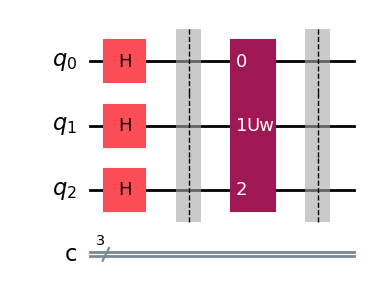

In [14]:
qc.draw('mpl')

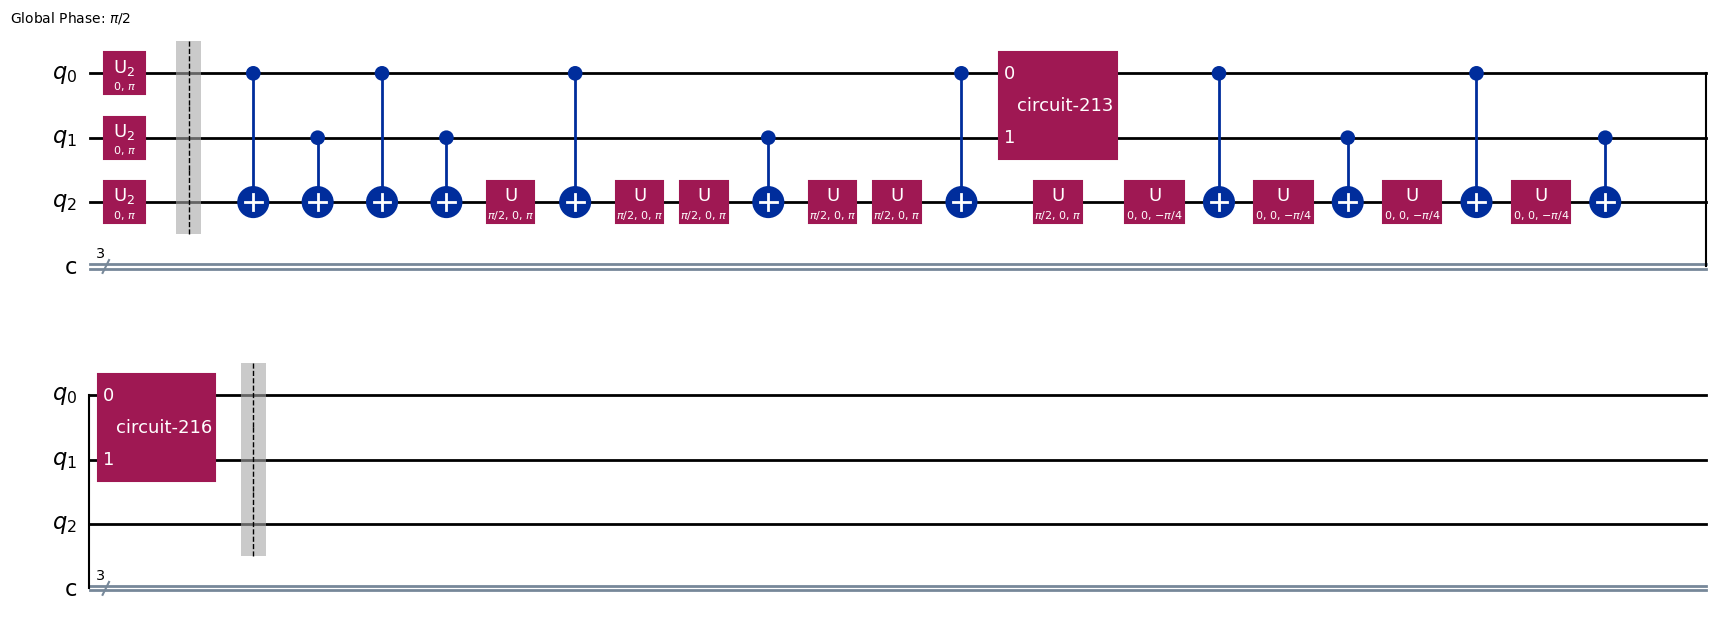

In [15]:
qc.decompose().draw('mpl')

In [18]:
def Diffucion():
    for i in range(n):
        qc.x(i)
        qc.h(i)
    qc.h(0)
    controls = []
    for i in range(1,n):
        controls.append(i)
    qc.mcx(controls,0)
    qc.h(0)
    qc.barrier()
    for i in range(n):
        qc.x(i)
        qc.h(i)
    return qc

The `Diffusion` function implements Groves diffusion operator, also called the **inversion about the mean** step 
This step amplifies the probability of measuring the correct solution by reinforcing the marked state and reducing the amplitude of all other states.

Grover’s **diffusion operator** is expressed as:

$
D = 2|\psi\rangle\langle\psi| - I
$

where $|\psi\rangle$ is the uniform superposition state.

This operation inverts the amplitudes of all states around their average, amplifying the marked state.

In [19]:
Diffucion()

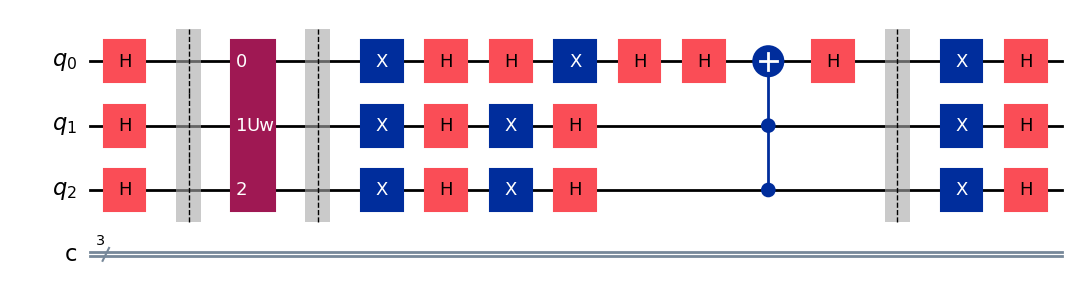

In [20]:
qc.draw('mpl')

In [21]:
from math import pi, sqrt, asin
theta = asin(1/sqrt(N))
t = ceil(pi/(4*theta)-0.5)

In [22]:
t

2

## **Optimal Number of Iterations in Grovers Algorithm**

1. **Computing `θ` (Rotation Angle)**
   
   $
   \theta = \sin^{-1} \left( \frac{1}{\sqrt{N}} \right)
   $

2. **Computing the Optimal Number of Iterations (`t`)**
   
   $
   t = \left\lceil \frac{\pi}{4\theta} - 0.5 \right\rceil
   $

   - `π / 4θ` represents the ideal number of rotations to align the state with the correct solution.
   - `ceil()` ensures rounding up to the nearest integer.

- **If `t` is too small**, the correct solution is not fully amplified.
- **If `t` is too large**, probability oscillations may cause incorrect results.
- This formula ensures **maximum probability** of finding the solution.

### **Example Calculation (If `N = 8`):**
1. Computing `θ`:
   
   $
   \theta = \sin^{-1} \left( \frac{1}{\sqrt{8}} \right) \approx 0.361
   $

2. Computing `t`:
   
   $
   t = \left\lceil \frac{3.141}{1.444} - 0.5 \right\rceil = \lceil 1.675 \rceil = 2
   $

Thus, **`t = 2` iterations** are needed for optimal probability of finding the solution.